In [1]:
# import of necessary modules
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt,sqrt,zeros,array,exp
from numpy import linalg
from scipy.integrate import odeint

In [2]:
# physical constants
hbarc = 197.326
M = (938.272 + 939.565) / 2.0 # averaged neutron/proton mass in MeV
units_factor = hbarc * hbarc / M
Nrows = 100  # 100: accurate, SRG takes some time! 50: less accurate, but faster

In [3]:
#arrays for uncoupled interaction channels
V = zeros([Nrows,Nrows],float)
Vmat = zeros([Nrows,Nrows],float)

#arrays for coupled interaction channels
Vcoupled = zeros([2*Nrows,2*Nrows],float)
Vmatcoupled = zeros([2*Nrows,2*Nrows],float)

#matrices for kinetic energy
Tkin = zeros([Nrows,Nrows],float)
Tkincoupled = zeros([2*Nrows,2*Nrows],float)

In [4]:
# read in nuclear interaction matrix elements for given uncoupled partial wave channels
def read_Vchiral(S, L, Lprime, J, T, Nrows):
    
    file = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,L,Lprime,J,T,Nrows)
    mesh=np.genfromtxt(file,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread=np.genfromtxt(file,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    V = zeros([Nrows,Nrows],float)
    Vmat = zeros([Nrows,Nrows],float)
    Tkin = zeros([Nrows,Nrows],float)
    
    for i in range(Nrows):
        Tkin[i,i] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V[i,j] = Vread[i*Nrows+j][2]        
            Vmat[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V[i,j]
            
    return [V, Vmat, Tkin, mesh_points, mesh_weights]

def read_AV18(S, L, Lprime, J, T, Nrows):
    
    file = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,L,Lprime,J,T,Nrows)
    mesh=np.genfromtxt(file,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread=np.genfromtxt(file,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    V = zeros([Nrows,Nrows],float)
    Vmat = zeros([Nrows,Nrows],float)
    Tkin = zeros([Nrows,Nrows],float)
    
    for i in range(Nrows):
        Tkin[i,i] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V[i,j] = Vread[i*Nrows+j][2]        
            Vmat[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V[i,j]
            
    return [V, Vmat, Tkin, mesh_points, mesh_weights]

# read in nuclear interaction matrix elements for given coupled channel block for a given S,J,T
def read_Vchiral_coupled(S, J, T, Nrows):
    
    file00 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J-1,J,T,Nrows)
    file01 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J+1,J,T,Nrows)
    file10 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J-1,J,T,Nrows)
    file11 = "store_VNN_TALENT/VNN_N3LO_EM500_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J+1,J,T,Nrows)
    mesh=np.genfromtxt(file00,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread00=np.genfromtxt(file00,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread01=np.genfromtxt(file01,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread10=np.genfromtxt(file10,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread11=np.genfromtxt(file11,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    
    V00 = zeros([Nrows,Nrows],float)
    V01 = zeros([Nrows,Nrows],float)
    V10 = zeros([Nrows,Nrows],float)
    V11 = zeros([Nrows,Nrows],float)
    Vcoupled = zeros([2*Nrows,2*Nrows],float)
    
    Vmat00 = zeros([Nrows,Nrows],float)
    Vmat01 = zeros([Nrows,Nrows],float)
    Vmat10 = zeros([Nrows,Nrows],float)
    Vmat11 = zeros([Nrows,Nrows],float)
    Vmatcoupled = zeros([2*Nrows,2*Nrows],float)
    Tkincoupled = zeros([2*Nrows,2*Nrows],float)
    
    for i in range(Nrows):
        Tkincoupled[i,i] = mesh_points[i] * mesh_points[i]
        Tkincoupled[i+Nrows,i+Nrows] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V00[i,j] = Vread00[i*Nrows+j][2]
            V01[i,j] = Vread01[i*Nrows+j][2]
            V10[i,j] = Vread10[i*Nrows+j][2]
            V11[i,j] = Vread11[i*Nrows+j][2]
            Vcoupled[i,j] = V00[i,j]
            Vcoupled[i,j+Nrows] = V01[i,j]
            Vcoupled[i+Nrows,j] = V10[i,j]
            Vcoupled[i+Nrows,j+Nrows] = V11[i,j]
            
            Vmat00[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V00[i,j]
            Vmat01[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V01[i,j]
            Vmat10[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V10[i,j]
            Vmat11[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V11[i,j]
            Vmatcoupled[i,j] = Vmat00[i,j]
            Vmatcoupled[i,j+Nrows] = Vmat01[i,j]
            Vmatcoupled[i+Nrows,j] = Vmat10[i,j]
            Vmatcoupled[i+Nrows,j+Nrows] = Vmat11[i,j]
            
    return [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights]

# read in nuclear interaction matrix elements for given coupled channel block for a given S,J,T
def read_AV18_coupled(S, J, T, Nrows):
    
    file00 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J-1,J,T,Nrows)
    file01 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J-1,J+1,J,T,Nrows)
    file10 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J-1,J,T,Nrows)
    file11 = "store_VNN_TALENT/VNN_AV18_SLLJT_%s%s%s%s%s_Np_%s_np.dat" % (S,J+1,J+1,J,T,Nrows)
    mesh=np.genfromtxt(file00,dtype=(float,float),skip_header=0,max_rows=Nrows)
    mesh_weights=mesh[:,0]
    mesh_points=mesh[:,1]
    
    Vread00=np.genfromtxt(file00,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread01=np.genfromtxt(file01,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread10=np.genfromtxt(file10,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    Vread11=np.genfromtxt(file11,dtype=(float,float,float),skip_header=Nrows,max_rows=Nrows*Nrows)
    
    V00 = zeros([Nrows,Nrows],float)
    V01 = zeros([Nrows,Nrows],float)
    V10 = zeros([Nrows,Nrows],float)
    V11 = zeros([Nrows,Nrows],float)
    Vcoupled = zeros([2*Nrows,2*Nrows],float)
    
    Vmat00 = zeros([Nrows,Nrows],float)
    Vmat01 = zeros([Nrows,Nrows],float)
    Vmat10 = zeros([Nrows,Nrows],float)
    Vmat11 = zeros([Nrows,Nrows],float)
    Vmatcoupled = zeros([2*Nrows,2*Nrows],float)
    Tkincoupled = zeros([2*Nrows,2*Nrows],float)
    
    for i in range(Nrows):
        Tkincoupled[i,i] = mesh_points[i] * mesh_points[i]
        Tkincoupled[i+Nrows,i+Nrows] = mesh_points[i] * mesh_points[i]
        for j in range(Nrows):
            V00[i,j] = Vread00[i*Nrows+j][2]
            V01[i,j] = Vread01[i*Nrows+j][2]
            V10[i,j] = Vread10[i*Nrows+j][2]
            V11[i,j] = Vread11[i*Nrows+j][2]
            Vcoupled[i,j] = V00[i,j]
            Vcoupled[i,j+Nrows] = V01[i,j]
            Vcoupled[i+Nrows,j] = V10[i,j]
            Vcoupled[i+Nrows,j+Nrows] = V11[i,j]
            
            Vmat00[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V00[i,j]
            Vmat01[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V01[i,j]
            Vmat10[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V10[i,j]
            Vmat11[i,j] = 2.0/np.pi*sqrt(mesh_weights[i]) * sqrt(mesh_weights[j]) * mesh_points[i] * mesh_points[j] * V11[i,j]
            Vmatcoupled[i,j] = Vmat00[i,j]
            Vmatcoupled[i,j+Nrows] = Vmat01[i,j]
            Vmatcoupled[i+Nrows,j] = Vmat10[i,j]
            Vmatcoupled[i+Nrows,j+Nrows] = Vmat11[i,j]
            
    return [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights]

In [5]:
# read in particular uncoupled or coupled matrix elements
S = 0
L = 0
Lprime = 0
J = 0
T = 1
Nrows = 100

[V, Vmat, Tkin, mesh_points, mesh_weights] = read_Vchiral(S,L,Lprime,J,T,Nrows)
# [V, Vmat, Tkin, mesh_points, mesh_weights] = read_AV18(S,L,Lprime,J,T,Nrows)

S = 1
J = 1
T = 0

[V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights] = read_Vchiral_coupled(S,J,T,Nrows)
# [V00, V01, V10, V11, Vmat00, Vmat01, Vmat10, Vmat11, Vcoupled, Vmatcoupled, Tkincoupled, mesh_points, mesh_weights] = read_AV18_coupled(S,J,T,Nrows)

In [6]:
#visualize the matrix elements in an uncoupled channel
def plot_V(V, maxindex):
    fig, (ax) = plt.subplots(nrows=1,ncols=1,figsize=(5, 5))
    maxabs = max(abs(V[:maxindex,:maxindex].min()),abs(abs(V)[:maxindex,:maxindex].max()))
    ax.set_xlabel("p [fm^{-1}]")
    ax.set_ylabel("p' [fm^{-1}]")
    ax.set_aspect('equal')
    im = ax.pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)

#visualize the matrix elements in a coupled channel
def plot_V_coupled(V00, V01, V10, V11, maxindex):
    fig, (ax) = plt.subplots(nrows=2,ncols=2,figsize=(10, 10))
    maxabs = max(abs(V00[:maxindex,:maxindex].min()),abs(abs(V00)[:maxindex,:maxindex].max()))
    ax[0,0].set_aspect('equal')
    ax[0,0].set_xlabel("p [fm^{-1}]")
    ax[0,0].set_ylabel("p' [fm^{-1}]")
    ax[0,1].set_xlabel("p [fm^{-1}]")
    ax[0,1].set_ylabel("p' [fm^{-1}]")
    ax[1,0].set_xlabel("p [fm^{-1}]")
    ax[1,0].set_ylabel("p' [fm^{-1}]")
    ax[1,1].set_xlabel("p [fm^{-1}]")
    ax[1,1].set_ylabel("p' [fm^{-1}]")
    im = ax[0,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V00[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[0,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V01[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[1,0].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V10[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)
    im = ax[1,1].pcolormesh(mesh_points[:maxindex], mesh_points[:maxindex], V11[:maxindex,:maxindex], vmin = -maxabs, vmax = maxabs, cmap='jet',rasterized=True)

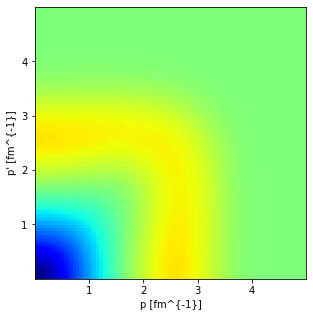

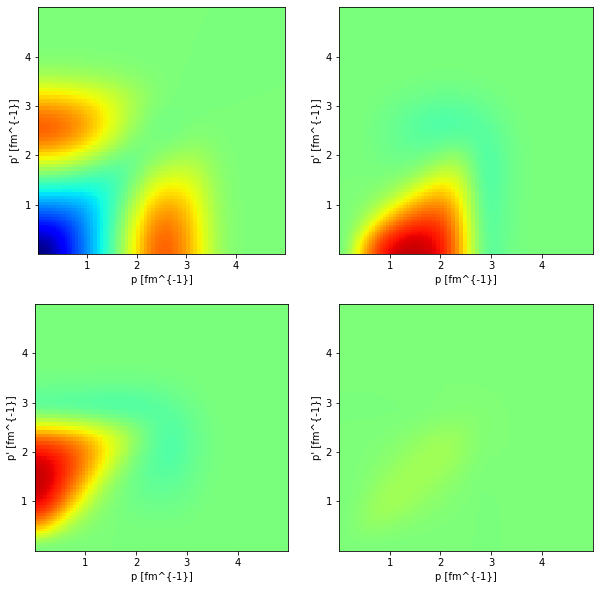

In [7]:
plot_V(V,Nrows)
plot_V_coupled(V00,V01,V10,V11,Nrows)

In [8]:
# computation of deuteron binding energy via diagonalization
def solve_deuteron(VmatSS, VmatSD, VmatDS, VmatDD, Nrows):  
    
    Hmat = zeros([2*Nrows,2*Nrows],float)
    for i in range(Nrows):
        Hmat[i,i] += units_factor * mesh_points[i] * mesh_points[i]
        Hmat[i + Nrows,i + Nrows] += units_factor * mesh_points[i] * mesh_points[i]

        for j in range(Nrows):
            Hmat[i,j] += units_factor * VmatSS[i,j]
            Hmat[i,j + Nrows] += units_factor * VmatSD[i,j]
            Hmat[i + Nrows,j] += units_factor * VmatDS[i,j]
            Hmat[i + Nrows,j + Nrows] += units_factor * VmatDD[i,j]
    
    w, v = linalg.eig(Hmat)
    idx = np.argsort(w)
    
    w = w[idx]
    psi_S = zeros(Nrows,float)
    psi_D = zeros(Nrows,float)
    for i in range(Nrows):
        psi_S[i] = v[i,idx[0]] 
        psi_D[i] = v[i+Nrows,idx[0]]
    return [w[0],psi_S,psi_D]

# computation of deuteron binding energy via diagonalization with an additional cut on the maximum momentum value
def solve_deuteron_cut(VmatSS, VmatSD, VmatDS, VmatDD, Nrows, pmax):  
    
    Nsize = 0
    while mesh_points[Nsize] < pmax:
        Nsize+=1
    
    Hmat = zeros([2*Nsize,2*Nsize],float)
    for i in range(Nsize):
        Hmat[i,i] += units_factor * mesh_points[i] * mesh_points[i]
        Hmat[i + Nsize,i + Nsize] += units_factor * mesh_points[i] * mesh_points[i]

        for j in range(Nsize):
            Hmat[i,j] += units_factor * VmatSS[i,j]
            Hmat[i,j + Nsize] += units_factor * VmatSD[i,j]
            Hmat[i + Nsize,j] += units_factor * VmatDS[i,j]
            Hmat[i + Nsize,j + Nsize] += units_factor * VmatDD[i,j]
    
    w, v = linalg.eig(Hmat)
    idx = np.argsort(w)
    w = w[idx]
    psi_S = zeros(Nsize,float)
    psi_D = zeros(Nsize,float)
    for i in range(Nsize):
        psi_S[i] = v[i,idx[0]] 
        psi_D[i] = v[i+Nsize,idx[0]]
        
    return [w[0],psi_S,psi_D]

In [9]:
print(solve_deuteron(Vmat00, Vmat01, Vmat10, Vmat11, Nrows) [0],solve_deuteron_cut(Vmat00, Vmat01, Vmat10, Vmat11, Nrows,4) [0])

-2.2245486414978273 -2.2243863061376112


In [10]:
[Edeut, psi_S, psi_D] = solve_deuteron(Vmat00, Vmat01, Vmat10, Vmat11, Nrows)
norm_S = 0.0
norm_D = 0.0
for i in range(Nrows):
    norm_S += psi_S[i]*psi_S[i]
    norm_D += psi_D[i]*psi_D[i]
    
print("E_d=",Edeut,"\n|psi_S|^2=",norm_S,"\n|psi_D|^2=",norm_D,"\n|psi|^2=",norm_S+norm_D,"\nP_D=",100*norm_D/(norm_S+norm_D),"%")

E_d= -2.2245486414978273 
|psi_S|^2= 0.9548585088832934 
|psi_D|^2= 0.04514149111670658 
|psi|^2= 1.0 
P_D= 4.514149111670658 %
